In [31]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [32]:
# Import necessary libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt 
import simpy as sp
import copy

import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [33]:
# Create simulation object now for reference, construct later
sim = None

In [34]:
# Define objects
class Node(object):
  # Properties
  label: int
  send_rate: float 
  mutate_rate: float 
  packets: set = None
  recieved: set = None

  # Metrics
  info_amount: int = 0
  cumulative_inacc: float = 0.0
  cumulative_rec: float = 0.0

  def __init__(self, env, label):
    # Create Node object
    self.label = label
    self.send_rate = np.abs(np.random.normal(scale=0.1))
    self.mutate_rate = np.random.normal()/10
    self.mutate_dist = lambda : np.abs(np.random.normal(scale=0.1))
    self.packets = list()
    self.recieved = set()
    self.env = env

    # Run Node object
    self.env.process(self.run(self.env))

  def run(self, env):
    
    while True:
      # Wait
      wait_time = np.random.exponential(1.0/self.send_rate)
      yield env.timeout(wait_time)

      # If no packets to send, continue
      if len(self.packets) == 0:
        # print("Node {} no packets to send".format(self.label))
        continue
      # Pick packet 
      packet = np.random.choice(self.packets)
      # print("Node {} sending packet {}".format(self.label, packet.label))
      self.packets.remove(packet)
      # Mutate packet
      if np.random.rand(1)[0] > self.mutate_rate:
        mutate_val = self.mutate_dist()
        # print("Node {} mutated packet {} by {}".format(self.label, packet.label, mutate_val))
        packet.inacc = max([0, packet.inacc + mutate_val])
      # Send packet
      # Can either pick a neighbor or send to all neighbors
      # We are currently sending to all neighbors
      for n in sim.G.neighbors(self.label):
        # If neighbor is a source, don't send
        if n not in sim.nodes:
          continue
        node = sim.nodes[n]
        assert(isinstance(node, Node))
        # Copy packet 
        copy_packet = copy.copy(packet)
        # If neighbor already recieved packet, don't send
        if copy_packet.label in node.recieved:
          continue
        # Add packet to neighbors mailbox and update cumulatives
        node.packets.append(copy_packet)
        node.recieved.add(copy_packet.label)
        node.info_amount += 1
        node.cumulative_inacc += copy_packet.inacc
        node.cumulative_rec += (env.now - copy_packet.time_stamp)

  def __str__(self):
    return "Node<label: {}, amount: {}, recency: {}>".format(self.label, self.info_amount, self.cumulative_rec)
    return "Node <label: {}, send_rate: {}, mutate_rate: {}>".format(self.label, self.send_rate, self.mutate_rate)

  def __repr__(self):
    return "Node<label: {}, amount: {}, recency: {}>".format(self.label, self.info_amount, self.cimulative_rec)

  def get_info_amount(self):
    return self.info_amount
    
  def get_info_inacc(self):
    return self.cumulative_inacc / float(self.info_amount) if self.info_amount != 0 else 0.0
    
  def get_info_recency(self):
    return self.cumulative_rec / float(self.info_amount) if self.info_amount != 0 else 0.0

class Source(object):
  # Properties
  label: int
  gen_rate: float

  def __init__(self, env, label):
    # Create Source object
    self.label = label
    self.gen_rate = np.abs(np.random.normal() / 10)
    
    # Run Source object
    env.process(self.run(env))

  def run(self, env):
    while True:
      # Wait
      wait_time = np.random.exponential(1.0/self.gen_rate)
      yield env.timeout(wait_time)
      # Create packet
      packet = Packet(env)
      # print("Source {} creating packet {}".format(self.label, packet.label))
      # Send packet
      # Can either pick a neighbor or send to all neighbors
      # We are currently sending to all neighbors
      for n in sim.G.neighbors(self.label):
        # print("Source {} sending to {}".format(self.label, n))
        # If neighbor is a source, don't send
        if n not in sim.nodes:
          continue
        node = sim.nodes[n]
        assert(isinstance(node, Node))
        # Copy packet 
        copy_packet = copy.copy(packet)
        # If neighbor already recieved packet, don't send
        if copy_packet.label in node.recieved:
          continue
        # Add packet to neighbors mailbox and update cumulatives
        node.packets.append(copy_packet)
        node.recieved.add(copy_packet.label)
        node.info_amount += 1
        node.cumulative_inacc += copy_packet.inacc
        node.cumulative_recency = (env.now - copy_packet.time_stamp)


  def __str__(self):
    return "Source <label: {}, gen_rate: {}>".format(self.label, self.gen_rate)

  def __repr__(self):
    return "Source<label: {}>".format(self.label)

class Packet(object):
  num_packets: int = 0
  label: int 
  inacc: float = 0.0
  time_stamp: int
  
  def __init__(self, env):
    self.label = Packet.num_packets
    Packet.num_packets += 1
    self.time_stamp = env.now

  def __str__(self):
    return "Packet <label: {}, inacc: {}, time_stamp: {}>".format(self.label, self.inacc, self.time_stamp)

  def __repr__(self):
    return "Packet<label: {}>".format(self.label)

In [38]:
# Define simulation, construct network, and network initiation
class Simulation(object):
  """
    Holds network information.
  """

  G: nx.Graph

  def __init__(self, nsources=3, nnodes=250, pedge=0.04):
    self.nnodes = nnodes
    self.spread_count = []
    self.misinfo_count = []
    self.env = sp.Environment()
    # Create network - scale-free network
    counter = 0
#     G_tmp = nx.scale_free_graph(nsources + nnodes).to_undirected()
    G_tmp = nx.scale_free_graph(nsources + nnodes, beta=pedge, alpha = (1-pedge)/2, gamma=(1-pedge)/2).to_undirected()
    
    # Convert scale free network into a simple graph
    self.G = nx.Graph()
    self.G.add_nodes_from(G_tmp)
    for u, v in G_tmp.edges():
      if not self.G.has_edge(u, v):
        self.G.add_edge(u, v)
    # self.G = nx.gnp_random_graph(nsources + nnodes, pedge)

    self.sources = dict()
    self.nodes = dict()
    for _ in range(nsources):
      self.sources[counter] = Source(self.env, counter)
      counter += 1
    for _ in range(nnodes):
      self.nodes[counter] = Node(self.env, counter)
      counter += 1

  def run(self, until):
    for i in range(1,until+1):
        
      self.env.run(until=i)
    
      # Calculate number of nodes that have been visited
      num_visited = sum([len(self.nodes[i].recieved) > 0 for i in self.nodes])
      self.spread_count.append((num_visited + len(self.sources))/self.nnodes)
      misinformed_count = len([n.get_info_inacc() for n in self.nodes.values() if n.get_info_inacc() > 0])
      self.misinfo_count.append(misinformed_count / self.nnodes)

  def graph(self, metric='amount'):

    # info_inaccs = [n.get_info_inacc() for n in self.nodes.values()]
    # info_recencies = [n.get_info_recency() for n in self.nodes.values()]

    # Position nodes
    pos = nx.kamada_kawai_layout(self.G)

    # Draw packet density graph
    # Calculate amounts, set size based on amounts
    info = None
    data = None
    title = None
    if metric=='amount':
        data = info = np.array([n.get_info_amount() for n in self.nodes.values()]).astype(float)
        title = 'Packet density'
    elif metric=='inacc':
        data = info = np.array([n.get_info_inacc() for n in self.nodes.values()]).astype(float)    
        title = 'Packet inaccuracy'        
    elif metric=='recency':
        data = info = np.array([n.get_info_recency() for n in self.nodes.values()]).astype(float)
        title = 'Packet recency'
    else:
        print("No metric of the name.")
        return
    
    info = info - min(info) 
    if max(info) != 0:
      info /= max(info)
    info = np.exp(5 * info + 1)
    np.linalg.norm(info)
  
    fig = plt.figure(1, figsize=(25, 25))
    fig.suptitle(title, fontsize=30)
    plt.axis('off')
    nx.draw_networkx_nodes(self.G, pos,
                           nodelist=list(self.sources.keys()),
                           node_color='black',
                           node_shape='s',
                           node_size=50)
    nx.draw_networkx_nodes(self.G, pos,
                           nodelist=list(self.nodes.keys()),
                           node_size=info,
                           node_color=info,
                           cmap='Reds')
    nx.draw_networkx_edges(self.G, pos,
                           edge_color='gray',
                           alpha=0.4)
    plt.show()
    # nx.draw(self.G, pos=pos, node_size=0, alpha=0.4, edge_color='r', font_size=12, with_labels=True)

    # plt.subplot(312)
    # plt.title('Packet accuracy')
    # nx.draw(self.G, pos=pos, node_size=0, alpha=0.4, edge_color='r', font_size=12, with_labels=True)

    # plt.subplot(313)
    # plt.title('Packet recency')
    # nx.draw(self.G, pos=pos, node_size=0, alpha=0.4, edge_color='r', font_size=12, with_labels=True)
    return data
    
  def hist(self, info, metric, num_bins = 10):
    n, bins, patches = plt.hist(info, num_bins)
    plt.xlabel(metric.capitalize())
    plt.ylabel('Count')
    plt.title("Node Histogram")
    plt.show()
    
  def above(self, info, threshold):
    return sum(i > threshold for i in info) 

  def below(self, info, threshold):
    return sum(i < threshold for i in info)

  def visualize(self, threshold = []):
        metrics = ['amount', 'inacc', 'recency']
        for metric in metrics:
            info = self.graph(metric)
            self.hist(info, metric)
            for i in threshold:
                print("Count above threshold " + str(i) + ": " + str(self.above(info, i)))
                print("Count below threshold " + str(i) + ": " + str(self.below(info, i)))

Our crude model currently has the following parmeters: all sources create packets based an approximate $\text{Exponential}(\theta)$ distribution, where $\theta \sim |\mathcal{N}(0, \frac{1}{10})|$, where the $\theta$ is sampled for each source. The exponential distribution is approximate because of the restrictions of running a continuous-time simulations on a computer. Similarly, nodes send packets following a similar construction. The probability of mutation is determined via a normal guassian distribution, and we sample from a unit uniform distribution when determining mutation of a packet or not.

In [39]:
sim = Simulation()
sim.run(150)

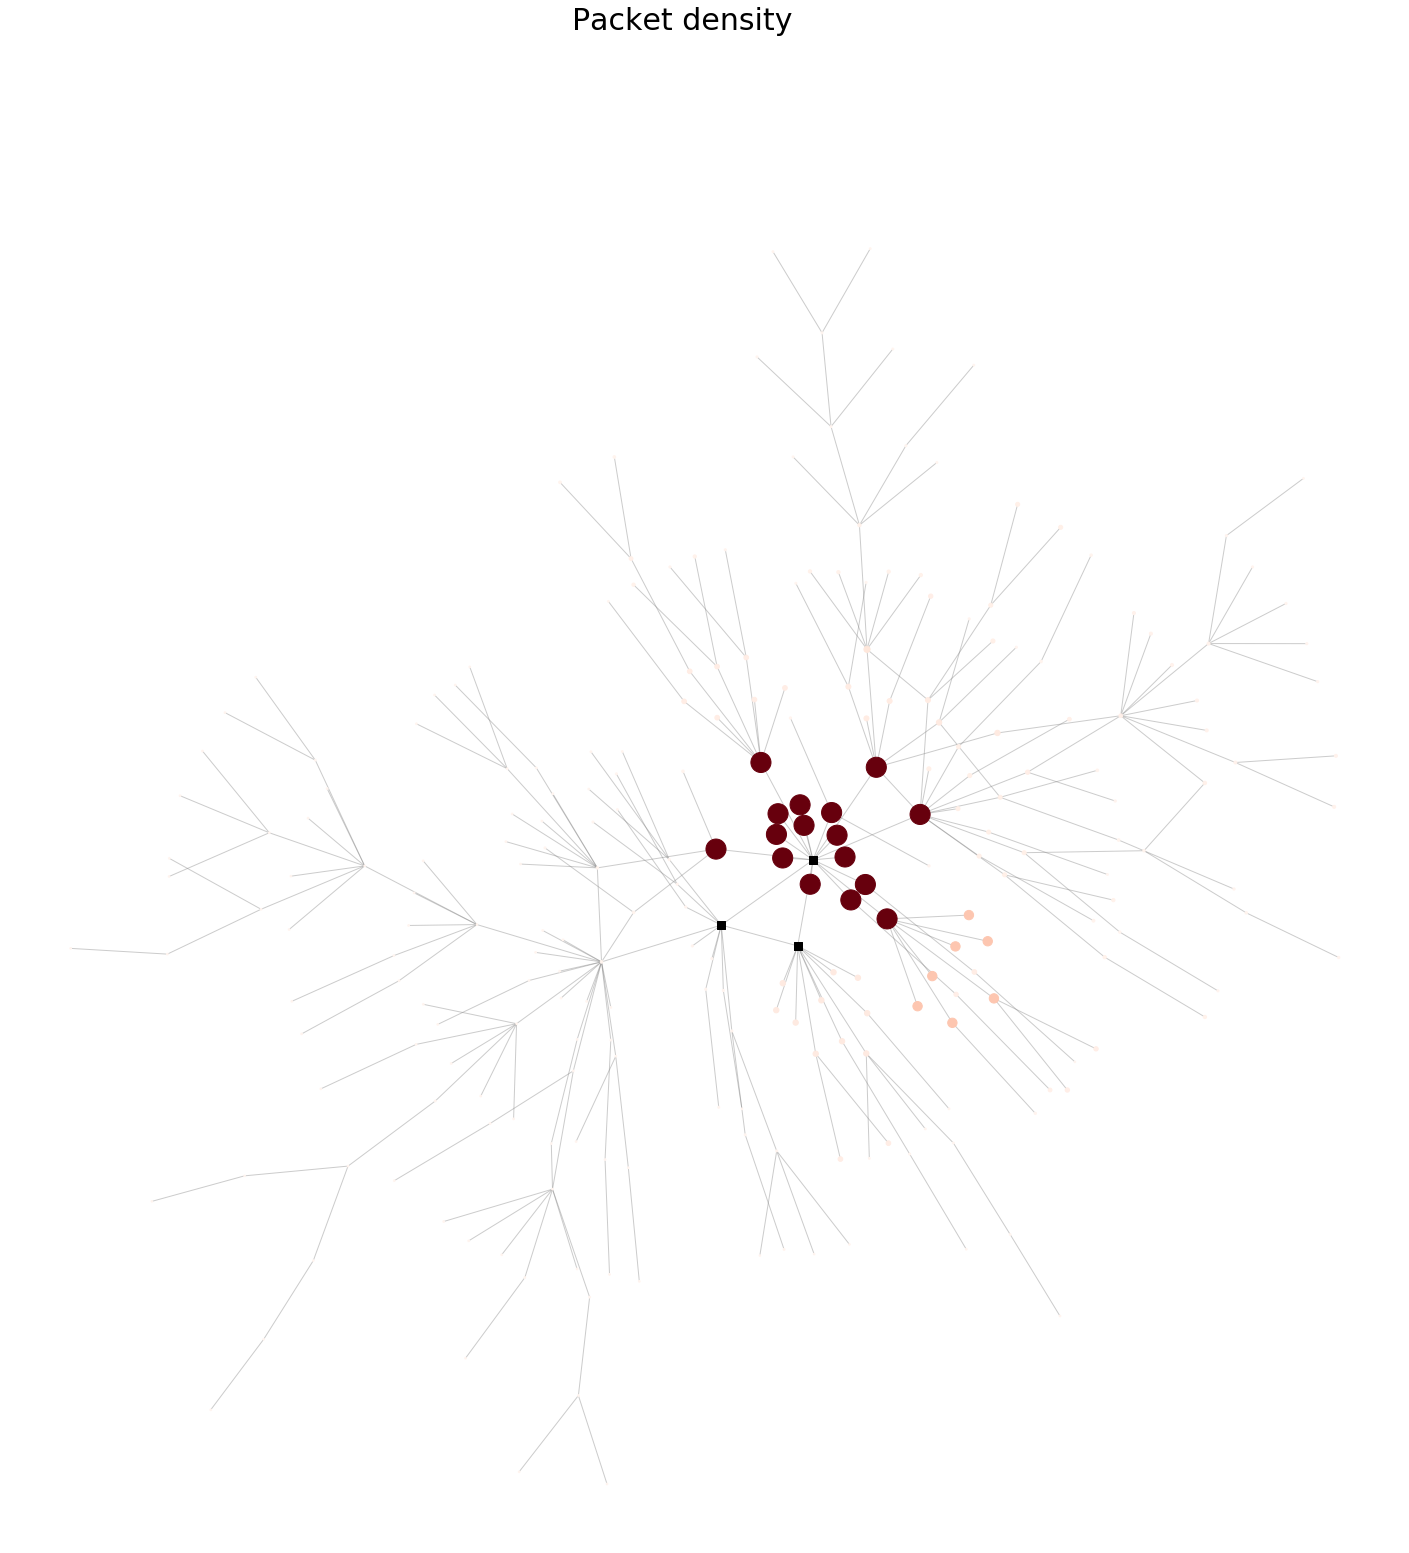

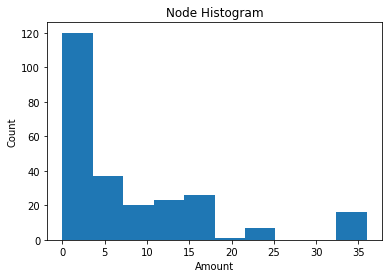

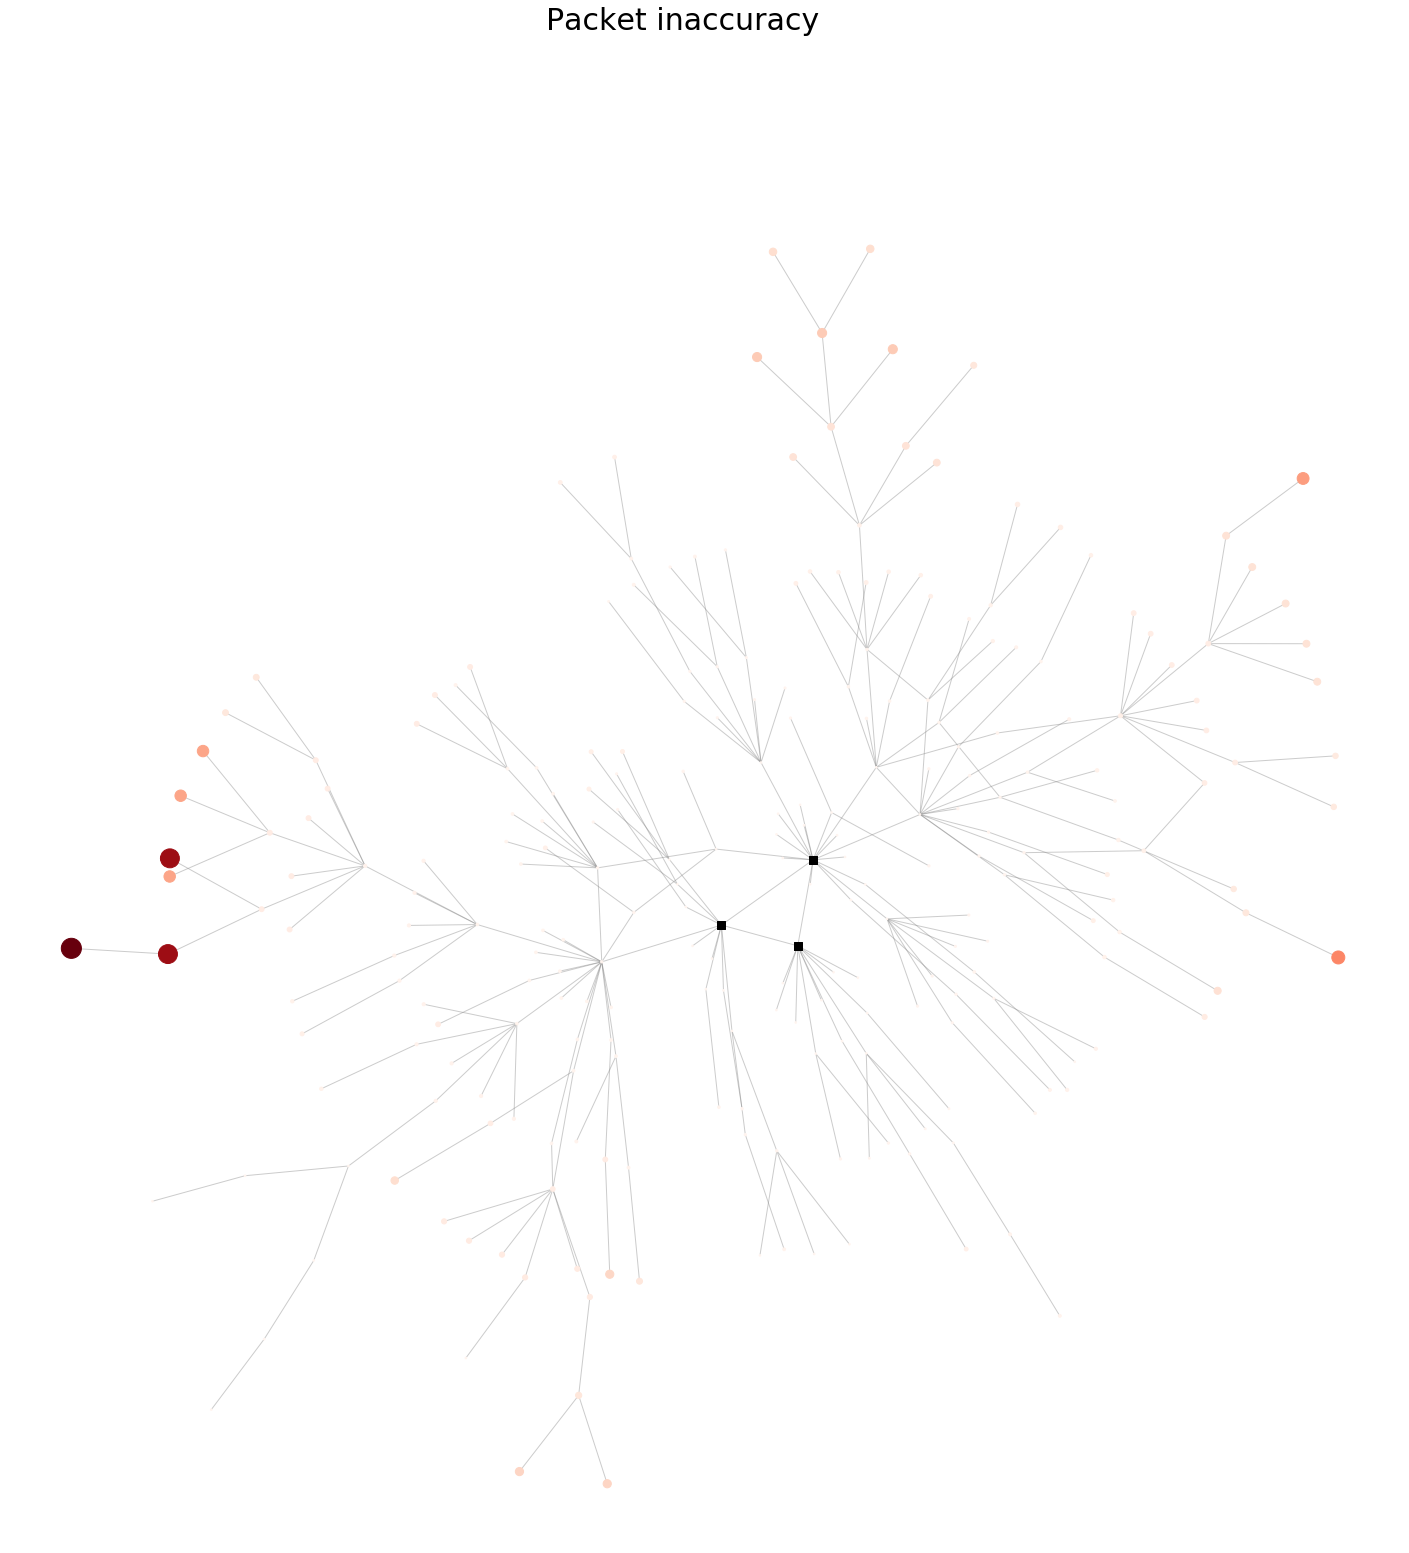

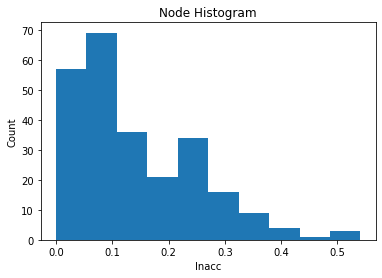

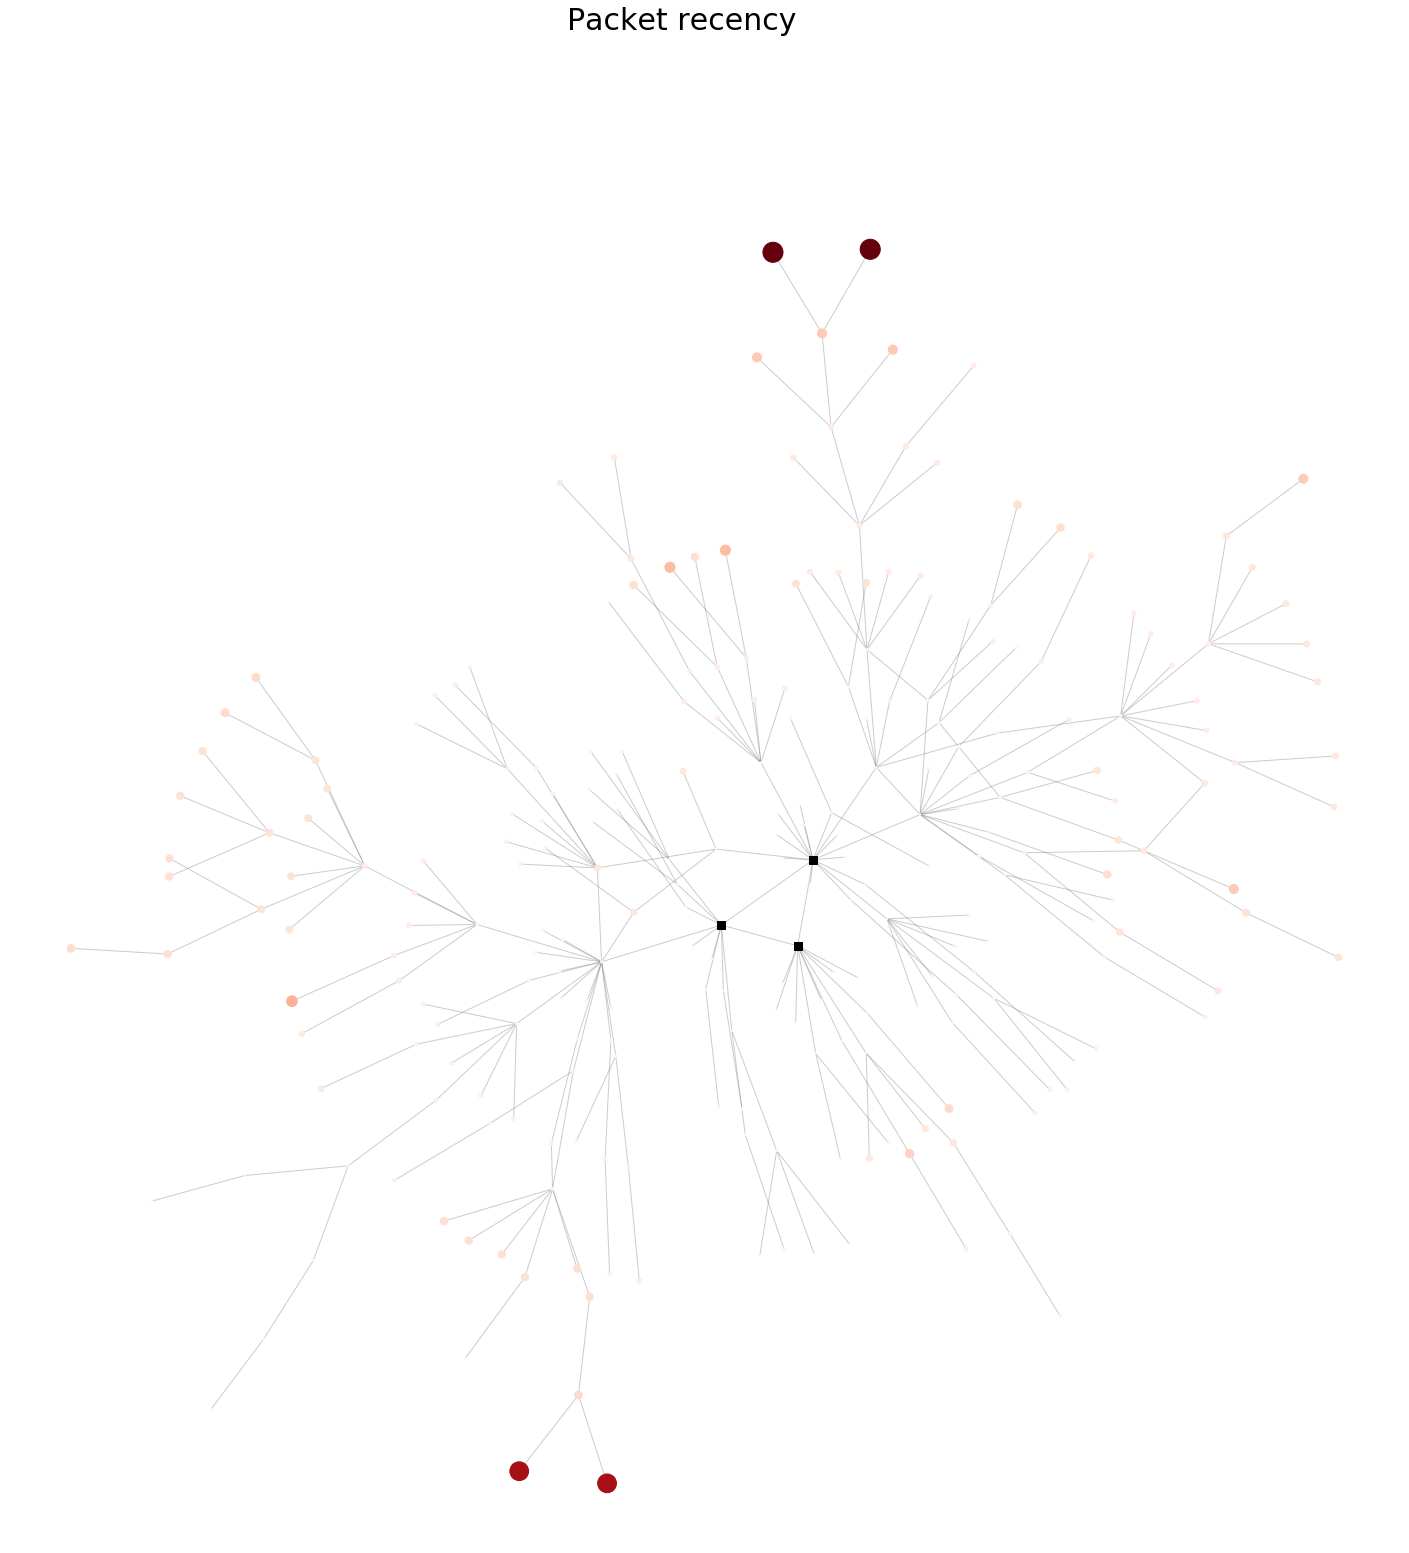

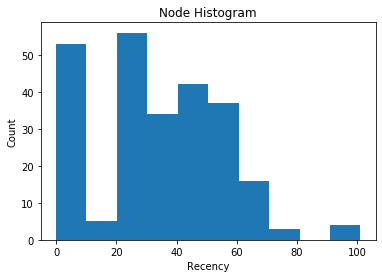

In [40]:
sim.visualize()

This graph represents the packet density of our model after 150 ticks of simulation time. As expected, nodes directly connected to sources recieve the most amount of packets.

# Testing Hypothesis

* Within log(n) timesteps, at least 50% of nodes will be affected by misinformation
* Simulations with multiple origins will reach majority infection on average faster than a single source, but does not necessarily scale linearly.

### Simulate

In [26]:
spread_df = pd.DataFrame()
misinfo_df = pd.DataFrame()

# Hyperparameters
runtime = 150
exp_n = 20 # Number of experiments for each source number
node_n = 250 # Number of nodes in graph
pedge = 0.3 # Edge probability when building graph
max_source_count = 25

# Run experiments for difference number of starting sources
for i in range(1,max_source_count+1):
    print(f'Testing with {i} sources')
    spread = []
    misinfo = []
    # Run exp_n experiments per source #
    for j in range(exp_n):
        sim = Simulation(nsources=i, nnodes=node_n+i, pedge=pedge)

        sim.run(runtime)
        spread.append(sim.spread_count)
        misinfo.append(sim.misinfo_count)
    spread_df[str(i) + ' Source'] = np.mean(spread, axis=0)
    misinfo_df[str(i) + ' Source'] = np.mean(misinfo, axis=0)
#     sns.lineplot(x=range(runtime),y=sim.spread_count, legend=i)

Testing with 1 sources
Testing with 2 sources
Testing with 3 sources
Testing with 4 sources
Testing with 5 sources
Testing with 6 sources
Testing with 7 sources
Testing with 8 sources
Testing with 9 sources
Testing with 10 sources
Testing with 11 sources
Testing with 12 sources
Testing with 13 sources
Testing with 14 sources
Testing with 15 sources
Testing with 16 sources
Testing with 17 sources
Testing with 18 sources
Testing with 19 sources
Testing with 20 sources
Testing with 21 sources
Testing with 22 sources
Testing with 23 sources
Testing with 24 sources
Testing with 25 sources


### Information Exposure over time

Text(0, 0.5, '% Nodes Visited')

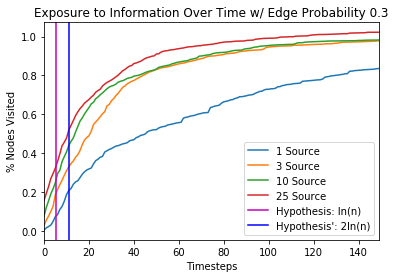

In [27]:
ax = spread_df.loc[:,['1 Source','3 Source','10 Source', '25 Source']].plot(title= f'Exposure to Information Over Time w/ Edge Probability {pedge}')
ax.axvline(x=np.log(node_n), color='m', label='Hypothesis: ln(n)')
ax.axvline(x=2*np.log(node_n), color='b', label='Hypothesis\': 2ln(n)')
ax.legend()
ax.set_xlabel("Timesteps")
ax.set_ylabel("% Nodes Visited")

More sources = faster spread of information

### Misinformation Exposure over time

Text(0, 0.5, '% Nodes Misinformed')

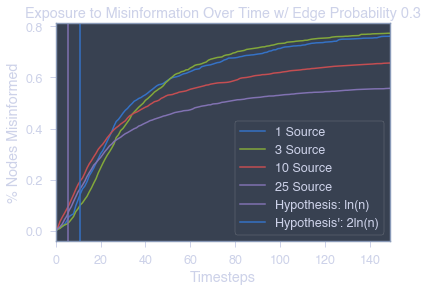

In [248]:
ax = misinfo_df.loc[:,['1 Source','3 Source','10 Source', '25 Source']].plot(title= f'Exposure to Misinformation Over Time w/ Edge Probability {pedge}')
ax.axvline(x=np.log(node_n), color='m', label='Hypothesis: ln(n)')
ax.axvline(x=2*np.log(node_n), color='b', label='Hypothesis\': 2ln(n)')
ax.legend()
ax.set_xlabel("Timesteps")
ax.set_ylabel("% Nodes Misinformed")

More sources = Less nodes being misinformed

### Proportion of Exposed Individuals being Misinformed

Text(0, 0.5, '% Misinformed')

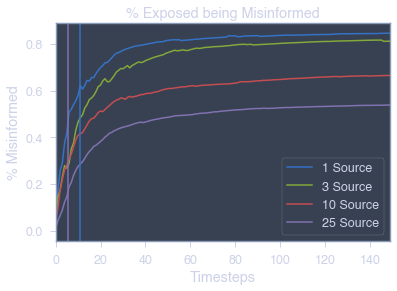

In [247]:
ax = (misinfo_df / spread_df).loc[:,['1 Source','3 Source','10 Source','25 Source']].plot(title= f'% Exposed being Misinformed')
ax.legend()
ax.axvline(x=np.log(node_n), color='m', label='Hypothesis: ln(n)')
ax.axvline(x=2*np.log(node_n), color='b', label='Hypothesis\': 2ln(n)')
ax.set_xlabel("Timesteps")
ax.set_ylabel("% Misinformed")

The more sources, the less that are misinformed

### Relationship between ****source number**** and ****time to reach 50% nodes****

Text(0, 0.5, '% Exposed')

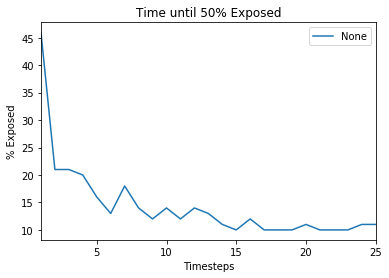

In [28]:
half_coverage= spread_df.apply(lambda x: (x > 0.5).idxmax())
half_coverage.index = half_coverage.index.str.extract(r'(.+)\s').astype(int)
ax = half_coverage.plot(title='Time until 50% Exposed')
# half_coverage
ax.legend()
ax.set_xlabel("Timesteps")
ax.set_ylabel("% Exposed")


In [29]:
half_exposed= spread_df.apply(lambda x: (x > 0.5).idxmax())
half_misinfo= misinfo_df.apply(lambda x: (x > 0.5).idxmax())

lf_coverage = pd.DataFrame(data={'Exposed':half_exposed, 'Misinformed':half_misinfo}, index = half_exposed.index)
half_coverage.index = half_coverage.index.str.extract(r'(.+)\s').astype(int)

AttributeError: Can only use .str accessor with string values!

Text(0, 0.5, 'Timesteps')

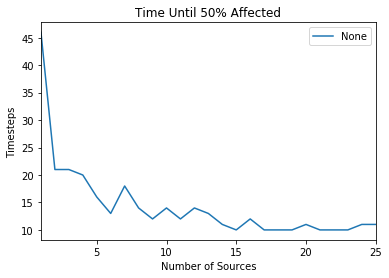

In [30]:
ax = half_coverage.plot(title='Time Until 50% Affected')
ax.legend()
ax.set_xlabel("Number of Sources")
ax.set_ylabel("Timesteps")

Misinformation slows down drastically as the number of sources increase while information (misinformed or not) is spread at an increasing rate